In [5]:
!pip install -q -U ultralytics
!pip install -U -q ipywidgets

In [6]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5689.9/8062.4 GB disk)


In [7]:
import os
import random
import glob
import shutil

import json
import yaml

from collections import defaultdict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

from lxml import etree as ET

import pandas as pd
import matplotlib.pyplot as plt

import cv2
# from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from IPython.display import display, Image

from sklearn.model_selection import train_test_split

In [1]:
pip install clip

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=b29c06f5beffa6b0fc31071e6e3d7804f551e2f486d8ccb4e86199292740227f
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [3]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Retrieving notices: ...working... done
Channels:
 - pytorch
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: / warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
failed

LibMambaUnsatisfiableError: Encountered problems while solving:
  - package pytorch-1.7.1-py3.6_cpu_0 requires python >=3.6,<3.7.0a0, but none of the providers can be installed
  - package cuda-version-12.1-h1f5ad73_2 has constraint cudatoolkit 12.1|12.1.* conflicting with cudatoolkit-11.0.221-h6bb024c_0

Could not solve for environment specs
The following packages are incompatible
├─ cuda-version 12.1**  is installable and it requires
│  └─ cudatoolkit 12.1|12.1.* , which can be installed;
├─ cudatoolkit 11.0**  is not installable because it conflicts with any installable versions previously reported;
├─ pin-1 is installable and it requires
│  └─ python 3.10.* , which can be installed;
└─ pytorch 1.7.1**  is not installable because there are no viable o

In [9]:
import os
import cv2
import torch
import torch.nn as nn
import pickle
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralytics import YOLO  # Ensure you have ultralytics package installed
import clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained feature extraction model
#model_path = '/kaggle/input/closest-img-model/resnet50_feature_extractor (1).pth'
clip_model_path = '/kaggle/input/prep-clip-model/clip_model_feature_extractor (2).pth'
#model = models.resnet50(pretrained=False)
#model = nn.Sequential(*list(model.children())[:-1])
#model.load_state_dict(torch.load(model_path, map_location=device))

model = clip.load("ViT-B/32", device=device)[0]
model.load_state_dict(torch.load(clip_model_path, map_location = device))

model.eval()

# Set device to GPU if available, else CPU
model = model.to(device)

# Load pre-computed image features
#features_path = '/kaggle/input/extracted-features/image_features.pkl'
features_path = '/kaggle/input/prep-clip-model/clip_image_features.pkl'
with open(features_path, 'rb') as f:
    image_features = pickle.load(f)

# Define image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess an image
def load_and_preprocess_image(image):
    img_tensor = preprocess(image)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

# Function to extract features from an image
def extract_features(image, model, device):
    img_tensor = load_and_preprocess_image(image).to(device)
    with torch.no_grad():
        #features = model(img_tensor)
        features = model.encode_image(img_tensor)
    return features.squeeze().cpu().numpy()

# Function to find the closest image and its label
def find_closest_image_and_label(cropped_image, image_features, data_folder, model, device):
    input_features = extract_features(cropped_image, model, device)
    similarities = {}
    for file_name, features in image_features.items():
        similarity = cosine_similarity([input_features], [features])[0][0]
        similarities[file_name] = similarity
    
    if not similarities:
        raise ValueError("No similarities found. Ensure that image features are correctly extracted.")
    
    closest_image = max(similarities, key=similarities.get)
    label_file = os.path.splitext(closest_image)[0] + '.txt'
    with open(os.path.join(data_folder, label_file), 'r') as f:
        label = f.read().strip()
    return closest_image, label

# Ensure output directory exists
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Load the YOLOv8 model
yolo_model = YOLO('/kaggle/input/model-det/best.pt')  # Replace with the correct model path if different

# Load the input image and get bounding boxes from YOLO model
#input_image_path = '/kaggle/input/example-img/1008198576.jpg'

Using device: cuda



image 1/1 /kaggle/input/full-cycle-examples/sberbank.png: 480x640 3 logos, 14.5ms
Speed: 2.6ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


100%|██████████| 54/54 [00:00<00:00, 3627.65it/s]

Cropped Image 0_0: Closest Image: sberbank.png, Label: sberbank


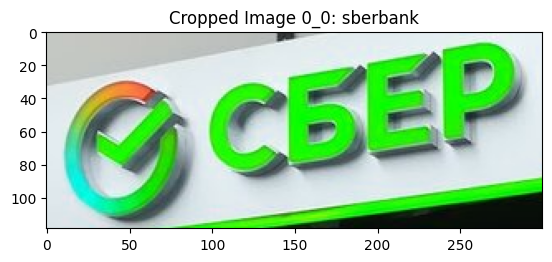

100%|██████████| 54/54 [00:00<00:00, 3612.95it/s]


Cropped Image 0_1: Closest Image: youdo.png, Label: youdo


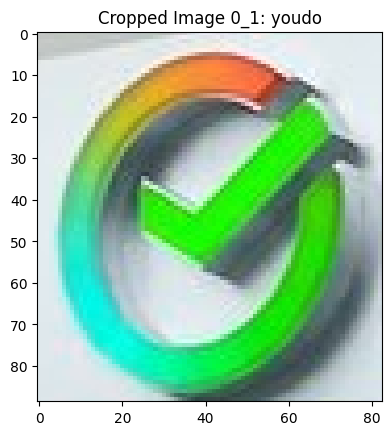

100%|██████████| 54/54 [00:00<00:00, 3637.26it/s]


Cropped Image 0_2: Closest Image: sberbank.png, Label: sberbank


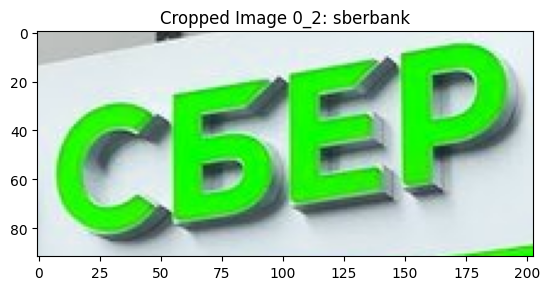

Cropped images and their labels saved to /kaggle/working/


In [17]:
input_image_path = '/kaggle/input/full-cycle-examples/sberbank.png'
input_image = Image.open(input_image_path)
results = yolo_model(input_image_path)

# Directory containing images and annotations
data_folder = '/kaggle/input/target-comps/company'

cropped_images_list = []

# Process results, crop images, and find labels
for i, result in enumerate(results):
    boxes = result.boxes
    img_cv2 = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)

    for j, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Convert to integer
        cropped_img_cv2 = img_cv2[y1:y2, x1:x2]
        cropped_img_pil = Image.fromarray(cv2.cvtColor(cropped_img_cv2, cv2.COLOR_BGR2RGB))

        # Find the closest image and its label for the cropped image
        try:
            closest_image, label = find_closest_image_and_label(cropped_img_pil, image_features, data_folder, model, device)

            # Save the cropped image
            output_image_path = os.path.join(output_dir, f'cropp_{i}_{j}.png')
            cropped_img_pil.save(output_image_path)

            # Print the label
            print(f'Cropped Image {i}_{j}: Closest Image: {closest_image}, Label: {label}')

            # Optionally, display the cropped image
            plt.imshow(cropped_img_pil)
            plt.title(f'Cropped Image {i}_{j}: {label}')
            plt.show()
        except Exception as e:
            print(f"Error processing cropped image {i}_{j}: {e}")

print(f'Cropped images and their labels saved to {output_dir}');

## Работа с файлами итп

In [4]:
import os

# Создаем директорию
os.makedirs('/kaggle/working/new_classification_data', exist_ok=True)

In [3]:
import os

# Создаем директорию
os.makedirs('/kaggle/working/sng_classification_data', exist_ok=True)

In [1]:
import os

# Создаем директорию
os.makedirs('/kaggle/working/local_classification_data', exist_ok=True)

In [1]:
import os

# Создаем директорию
os.makedirs('/kaggle/working/forbidden_classification_data', exist_ok=True)

In [39]:
import os
import shutil
from pathlib import Path
import zipfile

# Путь к исходному датасету
input_dir = '/kaggle/input/classification-data/openlogo_classes_and_logos_only'

# Список меток классов
labels = set()

# Новый датасет
output_dir = Path('new_dataset')
output_dir.mkdir(exist_ok=True)

# Перебор всех файлов в исходном датасете
for file in os.listdir(input_dir):
    # Пропускаем скрытые файлы
    if file.startswith('.'):
        continue

    # Обрабатываем только файлы с расширением .png и .txt
    ext = os.path.splitext(file)[1]
    if ext not in ['.png', '.txt']:
        continue

    # Извлекаем метку класса
    label = file.split('_')[0]

    # Пропускаем файлы с уже встреченными метками класса
    if label in labels:
        continue

    # Добавляем метку класса в список
    labels.add(label)

    # Копируем файл в новый датасет
    src_file = os.path.join(input_dir, file)
    dst_file = os.path.join(output_dir, file)
    shutil.copyfile(src_file, dst_file)

# Создаем zip-архив
zip_file = '/kaggle/working/new_classification_data.zip'
with zipfile.ZipFile(zip_file, 'w') as zip:
    for file in os.listdir(output_dir):
        zip.write(os.path.join(output_dir, file))

# Удаляем временный локальный датасет
shutil.rmtree(output_dir)

print("Новый датасет сохранен в zip-архиве")

Новый датасет сохранен в zip-архиве


In [40]:
import os
import zipfile

# Путь к исходному датасету
input_path = "/kaggle/input/classification-data/openlogo_classes_and_logos_only"
output_path = "/kaggle/working/new_classification_data"
zip_file_path = f"{output_path}.zip"

# Создаем директорию для нового датасета, если она не существует
os.makedirs(output_path, exist_ok=True)

# Инициализация словаря для хранения уникальных классов
unique_classes = {}

# Проходим по всем файлам в исходной директории
for file_name in os.listdir(input_path):
    if file_name.endswith('.txt'):
        txt_file_path = os.path.join(input_path, file_name)
        with open(txt_file_path, 'r') as file:
            class_label = file.read().strip()
        
        if class_label not in unique_classes:
            unique_classes[class_label] = file_name
            # Копируем txt файл
            os.system(f"cp {txt_file_path} {output_path}/{file_name}")
            # Копируем соответствующий png файл
            png_file_name = file_name.replace('.txt', '.png')
            png_file_path = os.path.join(input_path, png_file_name)
            if os.path.exists(png_file_path):
                os.system(f"cp {png_file_path} {output_path}/{png_file_name}")

# Создаем zip архив нового датасета
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk(output_path):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, output_path))

print(f"New dataset created and zipped at: {zip_file_path}")


New dataset created and zipped at: /kaggle/working/new_classification_data.zip


In [2]:
import os
import zipfile

# Путь к исходному датасету
input_path = "/kaggle/input/sng-companies/company_dop_"
output_path = "/kaggle/working/sng_classification_data"
zip_file_path = f"{output_path}.zip"

# Создаем директорию для нового датасета, если она не существует
os.makedirs(output_path, exist_ok=True)

# Проходим по всем файлам в исходной директории
for file_name in os.listdir(input_path):
    if file_name.endswith('.txt'):
        txt_file_path = os.path.join(input_path, file_name)
        with open(txt_file_path, 'r') as file:
            # Считываем содержимое файла и обрабатываем его
            content = file.read().strip()
            class_label = content.split()[0].lower()  # Берем первый элемент и приводим к нижнему регистру

        # Записываем обработанное содержимое в новый файл
        new_txt_file_path = os.path.join(output_path, file_name)
        with open(new_txt_file_path, 'w') as new_file:
            new_file.write(class_label)
        
        # Копируем соответствующий png файл
        png_file_name = file_name.replace('.txt', '.png')
        png_file_path = os.path.join(input_path, png_file_name)
        if os.path.exists(png_file_path):
            os.system(f"cp {png_file_path} {output_path}/{png_file_name}")

# Создаем zip архив нового датасета
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk(output_path):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, output_path))

print(f"New dataset created and zipped at: {zip_file_path}")

New dataset created and zipped at: /kaggle/working/sng_classification_data.zip


In [1]:
import os
import zipfile
from collections import defaultdict

# Путь к исходному датасету
input_path = "/kaggle/input/classification-data/openlogo_classes_and_logos_only"
output_path = "/kaggle/working/new_classification_data"
zip_file_path = f"{output_path}.zip"

# Создаем директорию для нового датасета, если она не существует
os.makedirs(output_path, exist_ok=True)

# Инициализация словаря для хранения уникальных классов и счетчика файлов
class_counts = defaultdict(int)
max_files_per_class = 4

# Проходим по всем файлам в исходной директории
for file_name in os.listdir(input_path):
    if file_name.endswith('.txt'):
        txt_file_path = os.path.join(input_path, file_name)
        with open(txt_file_path, 'r') as file:
            class_label = file.read().strip()
        
        # Проверяем, не превышено ли количество файлов для данного класса
        if class_counts[class_label] < max_files_per_class:
            class_counts[class_label] += 1
            # Копируем txt файл
            os.system(f"cp {txt_file_path} {output_path}/{file_name}")
            # Копируем соответствующий png файл
            png_file_name = file_name.replace('.txt', '.png')
            png_file_path = os.path.join(input_path, png_file_name)
            if os.path.exists(png_file_path):
                os.system(f"cp {png_file_path} {output_path}/{png_file_name}")

# Создаем zip архив нового датасета
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk(output_path):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, output_path))

print(f"New dataset created and zipped at: {zip_file_path}")


New dataset created and zipped at: /kaggle/working/new_classification_data.zip


In [4]:
import os
import zipfile

# Путь к исходному датасету
original_dataset_path = "/kaggle/input/sng-comps/company"

# Создать директорию для целевого датасета
os.makedirs("/kaggle/working/sng_classification_data", exist_ok=True)

# Получить список png-файлов
png_files = [f for f in os.listdir(original_dataset_path) if f.endswith(".png")]

# Создать txt-файлы для каждого png-файла
for png_file in png_files:
    # Получить название png-файла без расширения
    file_name = os.path.splitext(png_file)[0].lower()

    # Создать txt-файл
    with open(f"/kaggle/working/sng_classification_data/{file_name}.txt", "w") as txt_file:
        # Записать название класса в txt-файл
        txt_file.write(file_name)

# Создать zip-архив
with zipfile.ZipFile("/kaggle/working/sng_classification_data.zip", "w") as zip_file:
    for root, dirs, files in os.walk("/kaggle/working/sng_classification_data"):
        for file in files:
            zip_file.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), "/kaggle/working"))

In [3]:
import os
import zipfile

# Путь к исходному датасету
original_dataset_path = "/kaggle/input/forbidden/forbidden"

# Создать директорию для целевого датасета
os.makedirs("/kaggle/working/sng_classification_data", exist_ok=True)

# Получить список png-файлов
png_files = [f for f in os.listdir(original_dataset_path) if f.endswith(".png")]

# Создать txt-файлы для каждого png-файла
for png_file in png_files:
    # Получить название png-файла без расширения
    file_name = os.path.splitext(png_file)[0]

    # Создать txt-файл
    with open(f"/kaggle/working/sng_classification_data/{file_name}.txt", "w") as txt_file:
        # Записать название класса в txt-файл в нижнем регистре
        txt_file.write(file_name.lower())

# Создать zip-архив
with zipfile.ZipFile("/kaggle/working/forbidden_classification_data.zip", "w") as zip_file:
    for root, dirs, files in os.walk("/kaggle/working/sng_classification_data"):
        for file in files:
            zip_file.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), "/kaggle/working"))